<center><h1>StreamSoNG (Streaming Soft Neural Gas)</h1></center>

<hr />

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X1 = np.random.normal(-2, 2,(100, 2))
Y1 = np.zeros(len(X1))
X2 = np.random.normal(5, 4,(100, 2))
Y2 = np.zeros(len(X2)) + 1
X = np.concatenate((X1, X2), axis=0)
Y = np.concatenate((Y1, Y2), axis=0)

X.shape, Y.shape

((200, 2), (200,))

In [3]:
C = len(np.unique(Y))
"C", C

('C', 2)

# Neural Gas (NG)

In [4]:
class NeuralGas():
    def __init__(self, num_prototypes, dimension, step_size, neighborhood_range):
        self.num_prototypes = num_prototypes
        self.dimension = dimension
#         self.prototypes = np.random.random((num_prototypes, dimension))
        self.prototypes = np.random.normal(0, 4, (num_prototypes, dimension))
        self.prototype_labels = np.full(num_prototypes, np.nan)
        self.step_size = step_size
        self.neighborhood_range = neighborhood_range
    
    def initialize_prototypes(self, X, Y):
        indices = np.random.choice(len(X), self.num_prototypes)
        for i in range(len(indices)):
            self.prototypes[i] = X[indices[i]]
            self.prototype_labels[i] = Y[indices[i]]
    
    def visualize(self, X, Y):
        fig, ax = plt.subplots()
        
        # data
        ax.scatter(X[:, 0], X[:, 1], label="data", c=Y, cmap="Pastel1")
        
        # prototypes
        ax.scatter(self.prototypes[:, 0], self.prototypes[:, 1], c=self.prototype_labels, cmap="Set1", label="prototypes", marker="x")
        
        plt.show()
        
    def get_distance(self, a, b):
        return np.sum(np.power(a - b, 2))
    
    def learn(self, X):
        idx = np.random.choice(len(X))
        x = X[idx]
        
        distances = np.zeros(self.num_prototypes)
        for i in range(len(distances)):
            distances[i] = self.get_distance(x, self.prototypes[i])
        indices = np.argsort(distances)
        
        for k, i in enumerate(indices, 1):
            delta = self.step_size * np.exp(-k / self.neighborhood_range) * (x - self.prototypes[i])
            self.prototypes[i] += delta

In [5]:
num_prototypes = 5
dimension = 2
prototypes = []
prototype_labels = []

for c in range(C):
    indices = np.where(Y == c)
    X_c = X[indices]
    Y_c = Y[indices]
    ng = NeuralGas(num_prototypes=num_prototypes, dimension=dimension, step_size=0.01, neighborhood_range=2)
    ng.initialize_prototypes(X_c, Y_c)
    for epoch in range(20):
        ng.learn(X)
    prototypes.extend(ng.prototypes)
    prototype_labels.extend(ng.prototype_labels)

prototypes = np.array(prototypes)
prototype_labels = np.array(prototype_labels)
print(prototypes.shape, prototype_labels.shape)

(10, 2) (10,)


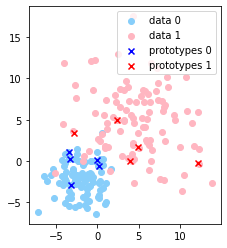

In [6]:
data_colors = ("lightskyblue", "lightpink")
prototype_colors = ("blue", "red")

fig, ax = plt.subplots()

# data
for c in range(C):
    indices = np.where(Y == c)
    X_c = X[indices]
    Y_c = Y[indices]
    ax.scatter(X_c[:, 0], X_c[:, 1], label=f"data {c}", color=data_colors[c])
    
# prototypes
for c in range(C):
    indices = np.where(prototype_labels == c)
    prototypes_c = prototypes[indices]
    ax.scatter(prototypes_c[:, 0], prototypes_c[:, 1], c=prototype_colors[c], label=f"prototypes {c}", marker="x")

ax.set_aspect(1)
plt.legend()
plt.show()

In [7]:
prototypes.shape

(10, 2)

# Probabilistic K-Nearest Neighbors (PKNN)

In [8]:
class PKNN():
    def __init__(self, prototypes, prototype_labels, num_classes, K, fuzzifier):
        self.prototypes = prototypes
        self.prototype_labels = prototype_labels.astype(int)
        self.num_classes = num_classes
        self.K = K
        self.fuzzifier = fuzzifier
    
    def num_prototypes(self):
        return self.prototypes.shape[0]
    
    def get_distance(self, a, b):
        return np.sum(np.power(a - b, 2))
    
    def euclidean_distance(self, a, b):
        return np.sqrt(np.sum(np.power(a - b, 2)))
    
    def knn(self, A, B, n=5, ignore_diag=False, distance_fx=None):
        if A.ndim == 1:
            A = A[None, :]
        if distance_fx is None:
            distance_fx = self.get_distance
        distances = np.full((len(A), len(B)), np.nan)
        for i in range(len(A)):
            for j in range(len(B)):
                if ignore_diag and i == j:
                    continue
                distances[i, j] = distance_fx(A[i], B[j])
            
        sorted_indices = np.argpartition(distances, kth=range(n), axis=1)[:, :n]
        shortest_distances= np.full((len(A), n), np.nan)
        for i in range(len(shortest_distances)):
            shortest_distances[i] = distances[i, sorted_indices[i]]
        return sorted_indices, shortest_distances
        
    def estimate_radius(self, n=5):
        if n >= self.num_prototypes():
            raise ValueError(f"n({n}) must be less than the number of prototypes({self.num_prototypes()})")
        self.radius = np.full(self.num_classes, np.nan)
        for c in range(self.num_classes):
            indices_c = np.where(self.prototype_labels == c)
            prototypes_c = self.prototypes[indices_c]
            _, shortest_distances = self.knn(prototypes_c, prototypes_c, n=n, ignore_diag=True, distance_fx=self.euclidean_distance)
            
            hist, bins = np.histogram(shortest_distances, bins=8)
            width = 0.7 * (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2
            self.radius[c] = mean = np.mean(center)
            
            fig, ax = plt.subplots()
            ax.bar(center, hist, align='center', width=width)
            ax.plot([mean] * (np.max(hist)+1), np.arange(np.max(hist)+1), color="red")
            ax.set_title(f"Class {c} $\eta = {mean:.3f}$")
    
    def compute_fuzzy_membership(self, n_i, pred, actual):
        if pred == actual:
            return 0.51 + (n_i / self.K) * 0.49
        else:
            return (n_i / self.K) * 0.49
    
    def compute_typicality(self, x, p, i):
        return 1 / (1 + (self.get_distance(x, p) / self.radius[i]) ** (1 / (self.fuzzifier-1)))
    
    def fuzzy_typicality(self, mu, t):
        return mu * t

    def average_typicality(self, fuzzy_typicalities):
        if np.sum(fuzzy_typicalities) == 0:
            return 0
        return np.nan_to_num(np.mean(fuzzy_typicalities))

    def s_function(self, x, a=0, b=0.5, c=1):
        if x <= 0:
            return 0
        elif a < x and x <= b:
            return ((x - a)** 2) / (2 * (b - a)**2)
        elif b < x and x <= c:
            return (-(x - c)** 2) / (2 * (b - c)**2)
        elif x > c:
            return 1
    
    def predict(self, x, j):
        sorted_indices, _ = self.knn(x, self.prototypes, n=self.K)
        t = 0

        # crisp membership ========================================================
        crisp_memberships = np.zeros(self.num_classes) # n_i
        for i in self.prototype_labels[sorted_indices[t]]:
            crisp_memberships[i] += 1
        pred_class = np.argmax(crisp_memberships)
        assert np.sum(crisp_memberships) == self.K

        # fuzzy membership ========================================================
        fuzzy_memberships = np.full(sorted_indices.shape[1], np.nan)
        for k, i in enumerate(self.prototype_labels[sorted_indices[t]]):
            fuzzy_memberships[k] = self.compute_fuzzy_membership(n_i=crisp_memberships[i], pred=i, actual=j)
        assert np.min(fuzzy_memberships) >= 0
        assert np.max(fuzzy_memberships) <= 1

        # typicality ==============================================================
        typicalities = np.full_like(fuzzy_memberships, np.nan)
        for k, idx in enumerate(sorted_indices[t]):
            p = self.prototypes[idx]
            i = self.prototype_labels[idx]
            typicalities[k] = self.compute_typicality(x, p, i)
        assert np.min(typicalities) >= 0
        assert np.max(typicalities) <= 1

        # fuzzy typicality ========================================================
        fuzzy_typicalities = np.full_like(typicalities, np.nan)
        for k, idx in enumerate(sorted_indices[t]):
            fuzzy_typicalities[k] = self.fuzzy_typicality(fuzzy_memberships[k], typicalities[k])
        assert np.min(fuzzy_typicalities) >= 0
        assert np.max(fuzzy_typicalities) <= 1

        # average typicality ======================================================
        pred_classes = self.prototype_labels[sorted_indices[t]]
        average_typicalities = np.full_like(crisp_memberships, np.nan)
        for i in range(self.num_classes):
            indices = np.where(pred_classes == i)
            average_typicalities[i] = self.average_typicality(fuzzy_typicalities[indices])
        assert np.min(average_typicalities) >= 0
        assert np.max(average_typicalities) <= 1

        # S function ==============================================================
        s_typicalities = np.full_like(average_typicalities, np.nan)
        for i in range(self.num_classes):
            s_typicalities[i] = self.s_function(average_typicalities[i])

        # class_typicality =========================================================
        class_closest = np.argmax(s_typicalities)
        typicality_class = s_typicalities[class_closest]
        return class_closest, typicality_class, sorted_indices[t]

## StreamSoNG

In [9]:
class StreamSoNG():
    def __init__(self, pknn, typicality_threshold, learning_rate=0.1, neighborhood_range=2):
        self.pknn = pknn
        self.typicality_threshold = typicality_threshold
        self.learning_rate = learning_rate
        self.neighborhood_range = neighborhood_range
        self.outliers = []
    
    def visualize(self, X, Y):
        data_colors = ("lightskyblue", "lightpink")
        prototype_colors = ("blue", "red")

        fig, ax = plt.subplots(figsize=(10, 10))

        # data
        for c in range(self.pknn.num_classes):
            indices = np.where(Y == c)
            X_c = X[indices]
            Y_c = Y[indices]
            ax.scatter(X_c[:, 0], X_c[:, 1], label=f"data {c}", color=data_colors[c])

        # prototypes
        for c in range(C):
            indices = np.where(prototype_labels == c)
            prototypes_c = self.pknn.prototypes[indices]
            ax.scatter(prototypes_c[:, 0], prototypes_c[:, 1], c=prototype_colors[c], label=f"prototypes {c}", marker="x")
            for i in range(len(prototypes_c)):
                x = prototypes_c[i, 0]
                y = prototypes_c[i, 1]
                circle = plt.Circle((x, y), self.pknn.radius[c], color=prototype_colors[c], fill=False, linestyle="--")
                ax.add_patch(circle)

        ax.set_aspect(1)
        plt.legend()
        plt.show()
    
    def process(self, x, j):
        x = X[t]
        j = Y[t]
        class_closest, typicality_class, closest_indices = self.pknn.predict(x, j)
        if typicality_class > self.typicality_threshold:
            for k, closest_idx in enumerate(closest_indices):
                self.update(k, closest_idx, typicality_class)
        else:
            self.outliers.append(x)
            
    def update(self, k, prototype_idx, typicality_class):
        self.pknn.prototypes[prototype_idx] += self.learning_rate * typicality_class * np.exp((-k / self.neighborhood_range)) * (x - self.pknn.prototypes[prototype_idx])

In [10]:
pknn = PKNN(prototypes=prototypes, prototype_labels=prototype_labels, num_classes=C, K=3, fuzzifier=1.5)

In [11]:
streamsong = StreamSoNG(pknn=pknn, typicality_threshold=0.2)

array([2.39415646, 6.46010708])

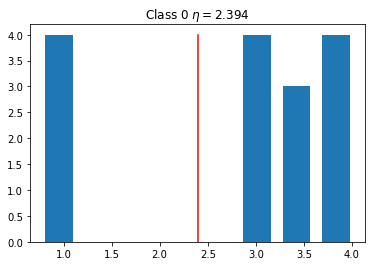

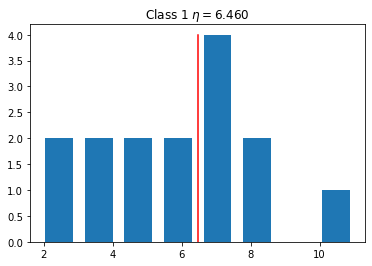

In [12]:
streamsong.pknn.estimate_radius(n=3)
streamsong.pknn.radius

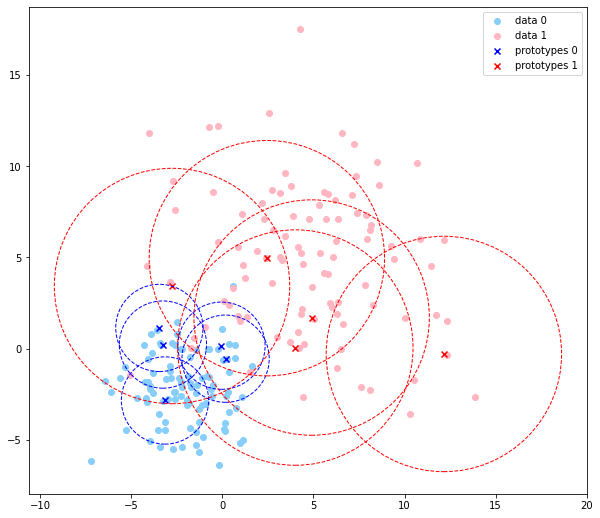

In [13]:
streamsong.visualize(X, Y)

In [14]:
for epoch in range(1):
    for t in range(X.shape[0]):
        x = X[t]
        j = Y[t]
        streamsong.process(x, j)

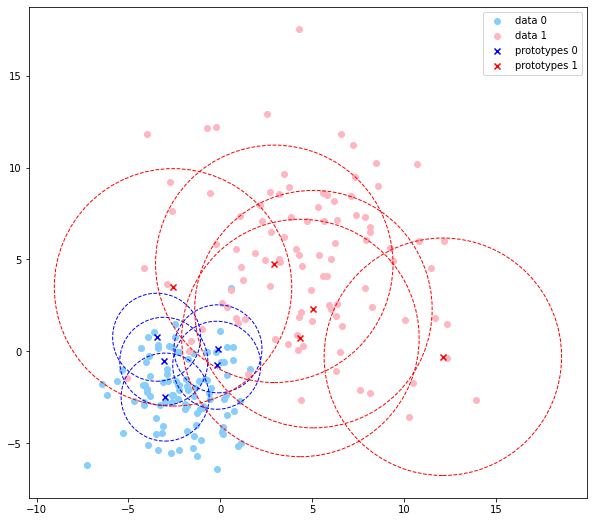

In [15]:
streamsong.visualize(X, Y)